In [1]:
%matplotlib inline
import os
from pynq import Overlay
from pynq import allocate
import xrfclk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from axififo import AxiStreamFifoDriver
import scipy.signal
import scipy.io
import time
import serial
from datetime import datetime

In [2]:
#ol = Overlay("hw/top_20240111_104744.bit", download=True) used to generate plots sent on slack on 1/11/24
#ol = Overlay("hw/top_20240112_123937.bit", download=True) partially working triangle waves, data_out.valid isn't enabled on any channel except channel 0
#ol = Overlay("hw/top_20240112_141513.bit", download=True)
#ol = Overlay("hw/top_20240112_152837.bit", download=True)
#ol = Overlay("hw/top_20240114_140538.bit", download=True)
#ol = Overlay("hw/top_20240114_195802.bit", download=True) # added disable for triggered-start of ADC buffer until buffer has been read out by DMA
#ol = Overlay("hw/top_20240114_225340.bit", download=True) # ILA, fixed disable? added output register to read the state of the ADC buffer
#ol = Overlay("hw/top_20240115_102015.bit", download=True) # can't get ILA to work
#ol = Overlay("hw/top_20240115_111719.bit", download=True) # actually works
ol = Overlay("hw/top_20240115_160553.bit", download=True) # added offset to dac_prescaler
xrfclk.set_ref_clks(lmk_freq=122.88, lmx_freq=409.6)

In [3]:
dac_fsamp = 6.144e9 #Hz
dds_phase_bits = 32
tri_phase_bits = 32
scale_bits = 18
offset_bits = 14
scale_offset_int_bits = 2

verbose = False

adc_fsamp = 4.096e9 # Hz

awg_frame_depth_max = 2048 # don't change
awg_frame_depth = 2048 # multiply by 16 to get total samples
adc_buffer_data_depth = 2048
adc_buffer_tstamp_depth = 512
tstamp_width = 64

parallel_samples = 16
sample_width = 16
num_channels = 8

awg_dma = ol.axi_dma_0.sendchannel
adc_dma = ol.axi_dma_0.recvchannel
# 8x2048-deep data buffer (256b/word)
# 8x512-deep timestamp buffer (64b/word)
# information:
# 8x2x(64+256)
adc_dma_bits = num_channels*adc_buffer_data_depth*parallel_samples*sample_width # data buffer
adc_dma_bits += num_channels*adc_buffer_tstamp_depth*tstamp_width # timestamp buffer
adc_dma_bits += num_channels*2*(parallel_samples*sample_width+tstamp_width) # timestamp+data channel ID/ sample count info
adc_buffer = allocate(shape=(adc_dma_bits//64,), dtype=np.uint64)
# 8 x awg_frame_depth - deep data buffer (256b/word, 16 samples/word)
awg_buffer = allocate(shape=(num_channels*awg_frame_depth*parallel_samples,), dtype=np.uint16)

def clog2(x):
    return int(np.ceil(np.log2(x)))

def packetize(long_word, num_words):
    packet = []
    if verbose:
        print(f'packetizing word {long_word:#0{num_words*8}x} into {num_words} words')
    for word in range(num_words):
        packet.append(long_word & ((1 << 32) - 1))
        long_word >>= 32
    if long_word != 0:
        print(f'WARNING: packetize has leftover data {hex(long_word)}')
    return packet

def receive_adc_data(override_capture_done_error=False):
    if override_capture_done_error:
        adc_dma.transfer(adc_buffer)
        return
        
    num_pkts = ol.buffer_capture_done.fifo.read_num_rx_words()
    if num_pkts != 2:
        print(f"WARNING: didn't get the right number of packets on capture_done, should be exactly 2 (one for when capture_done went low, one for when it went high again)")
        return
    pkt_0 = ol.buffer_capture_done.fifo.get_rx_fifo_pkt()[0]
    if pkt_0 != 0:
        print(f'WARNING: first capture_done packet should be zero')
        print(f'try manually triggering the ADC buffer')
    else:
        pkt_1 = ol.buffer_capture_done.fifo.get_rx_fifo_pkt()[0]
        if pkt_1 != 1:
            print(f'WARNING: second capture_done packet should be one')
            print(f'try manually triggering the ADC buffer')
        else:
            if verbose:
                print(f'capture_done is asserted')
            adc_dma.transfer(adc_buffer)
    
def send_awg_data():
    awg_dma.transfer(awg_buffer)

def set_vga_atten_dB(atten_dB):
    for channel in range(num_channels):
        atten = round(atten_dB[channel])
        if atten < 0 or atten > 32:
            raise ValueError(f"atten_dB {atten} out of range, pick a number between 0 and 32dB")
        packet = 0x0200 | (atten & 0x3f) # address 0x02, 6-bit data atten_dB
        packet |= channel << 16 # address/channel ID is above 16-bit address+data
        if verbose:
            print(f'sending packet {packet} to lmh6401_config.fifo')
        ol.lmh6401_config.fifo.send_tx_pkt([packet])
    
def set_dac_scale_offset(scales, offsets):
    scale_offset_word = 0
    scale_frac_bits = scale_bits - scale_offset_int_bits
    offset_frac_bits = offset_bits - scale_offset_int_bits
    
    for channel in range(num_channels):
        # scale is 2Q16, so quantize appropriately
        quant_scale = int(scales[channel] * 2**scale_frac_bits)
        quant_offset = int(offsets[channel] * 2**offset_frac_bits)
        if (scales[channel] >= 1 or scales[channel] < -1):
            raise ValueError(f'cannot quantize {scales[channel]} to {scale_offset_int_bits}Q{scale_frac_bits}')
        if (offsets[channel] >= 1 or offsets[channel] < -1):
            raise ValueError(f'cannot quantize {offsets[channel]} to {scale_offset_int_bits}Q{offset_frac_bits}')
        if quant_scale < 0:
            quant_scale += 2**scale_bits
        if quant_offset < 0:
            quant_offset += 2**offset_bits
        scale_offset_word |= quant_scale << ((scale_bits + offset_bits) * channel + offset_bits)
        scale_offset_word |= quant_offset << ((scale_bits + offset_bits) * channel)
    if verbose:
        print(f'sending scale_word {hex(scale_offset_word)} to dac_scale_config.fifo')
    ol.dac_scale_offset_config.fifo.send_tx_pkt(packetize(scale_offset_word, ((scale_bits+offset_bits)*num_channels)//32))

def set_dds_freq(freqs_hz):
    pinc_word = 0
    for channel in range(num_channels):
        pinc = int((freqs_hz[channel]/dac_fsamp)*(2**dds_phase_bits))
        pinc_word |= pinc << (dds_phase_bits * channel)
    if verbose:
        print(f'sending pinc_word {hex(pinc_word)} to dds_phase_inc.fifo')
    ol.dds_phase_inc.fifo.send_tx_pkt(packetize(pinc_word, (dds_phase_bits * num_channels + 31) // 32))
    
def set_tri_freq(freqs_hz):
    pinc_word = 0
    for channel in range(num_channels):
        pinc = int((freqs_hz[channel]/dac_fsamp)*(2**tri_phase_bits))
        pinc_word |= pinc << (tri_phase_bits * channel)
    if verbose:
        print(f'sending pinc_word {hex(pinc_word)} to tri_phase_inc.fifo')
    ol.tri_phase_inc.fifo.send_tx_pkt(packetize(pinc_word, (tri_phase_bits * num_channels + 31) // 32))
    
def set_awg_triggers(trigger_modes):
    trigger_word = 0
    for channel in range(num_channels):
        if trigger_modes[channel] not in range(0,3):
            raise ValueError(f'invalid selection for trigger mode ({trigger_modes[channel]}) on channel ({channel})')
        trigger_word |= trigger_modes[channel] << (2*channel)
    if verbose:
        print(f'sending trigger_word {hex(trigger_word)} to awg_trigger_out_config.fifo')
    ol.awg_trigger_out_config.fifo.send_tx_pkt([trigger_word])
    
def set_awg_burst_length(burst_lengths):
    packet = []
    for channel in range(num_channels):
        packet.append(burst_lengths[channel] & ((1 << 32) - 1))
        packet.append((burst_lengths[channel] >> 32) & ((1 << 32) - 1))
    if verbose:
        print(f'sending packet {packet} to awg_burst_length.fifo')
    ol.awg_burst_length.fifo.send_tx_pkt(packet)
    
def set_awg_frame_depth(depths):
    frame_depth_word = 0
    for channel in range(num_channels):
        if depths[channel] not in range(0, awg_frame_depth + 1):
            raise ValueError(f'invalid frame depth ({depths[channel]}) for channel ({channel})')
        frame_depth_word |= depths[channel] << (clog2(awg_frame_depth_max+1)*channel)
    if verbose:
        print(f'sending frame_depth word = {hex(frame_depth_word)} to awg_frame_depth.fifo')
    ol.awg_frame_depth.fifo.send_tx_pkt(packetize(frame_depth_word, (clog2(awg_frame_depth_max+1)*num_channels + 31)//32))

def start_awg():
    ol.awg_start_stop.fifo.send_tx_pkt([2])
    
def stop_awg():
    ol.awg_start_stop.fifo.send_tx_pkt([1])

def start_adc_buffer():
    ol.buffer_start_stop.fifo.send_tx_pkt([0x2])
    
def stop_adc_buffer():
    ol.buffer_start_stop.fifo.send_tx_pkt([0x1])

def sink_select_all_adcs():
    ol.adc_mux_config.fifo.send_tx_pkt([0x76543210])

def source_select(sources):
    mux_word = 0
    for channel in range(num_channels):
        if sources[channel] not in range(3*num_channels):
            raise ValueError(f'invalid signal source index ({sources[channel]}), pick one between 0 and {3*num_channels}')
        mux_word |= sources[channel] << (clog2(3*num_channels)*channel)
    if verbose:
        print(f'sending dac mux_word {hex(mux_word)} to dac_mux_config.fifo')
    ol.dac_mux_config.fifo.send_tx_pkt(packetize(mux_word, (clog2(3*num_channels)*num_channels + 31)//32)) # packetize into 2x 32b quantities
    
def source_select_all_dds():
    source_select(list(range(num_channels,2*num_channels)))
    
def source_select_all_awg():
    source_select(list(range(num_channels)))
    
def source_select_all_tri():
    source_select(list(range(2*num_channels,3*num_channels)))

def set_buffer_num_active_channels(num_active_channels):
    # todo accomodate more than 8 channels
    if num_active_channels not in [1,2,4,8]:
        raise ValueError(f'Incorrect number of active channels: {num_active_channels}, expected one of [1,2,4,8]')
    banking_mode = clog2(num_active_channels)
    if verbose:
        print(f'sending banking mode packet {banking_mode} to buffer_config.fifo')
    ol.buffer_config.fifo.send_tx_pkt([banking_mode])

def set_sample_discriminator_config(low_thresholds, high_thresholds):
    packet = []
    for channel in range(8):
        low = low_thresholds[channel]
        high = high_thresholds[channel]
        if low not in range(0,2**sample_width):
            raise ValueError(f'invalid low_threshold ({hex(low)}) for channel {channel}, should be between 0x00 and 0xff')
        if high not in range(0,2**sample_width):
            raise ValueError(f'invalid high_thresholds ({hex(high)}) for channel {channel}, should be between 0x00 and 0xff')
        packet.append((high << sample_width) | low)
    if verbose:
        print(f'sending sample_discriminator packet {packet} to sample_discriminator_config.fifo')
    ol.sample_discriminator_config.fifo.send_tx_pkt(packet)

def set_trigger_manager_config(combine_mode, mask):
    if mask not in range(0, 2**(2*num_channels)):
        raise ValueError(f'Incorrect mask value {hex(mask)}, should be an {2*num_channels}-bit quantity')
    if combine_mode.lower() not in ['and', 'or']:
        raise ValueError(f'Incorrect combine mode {combine_mode}, should be and/or (case insensitive)')
    comb_bit = 1 if combine_mode.lower() == 'and' else 0
    word = (comb_bit << (2*num_channels)) | mask
    if verbose:
        print(f'sending word {hex(word)} to trigger_manager_config.fifo')
    ol.trigger_manager_config.fifo.send_tx_pkt([word])
    
def parse_adc_data(num_active_channels):
    if num_active_channels not in [1,2,4,8]:
        raise ValueError(f'Incorrect number of active channels: {num_active_channels}, expected one of [1,2,4,8]')
    dma_word = 0
    dma_word_leftover_bits = 0
    dma_buffer_index = 0
    word_width = 64 # until we get the axis-register to work, don't use get_tstamp_width()
    word_mask = (1 << word_width) - 1
    parse_mode = "timestamp"
    need_channel_id = True
    need_word_count = True
    parsed_bank_count = 0
    done_parsing = False
    words_remaining = None
    # TODO generalize for banking mode other than 0x2
    timestamps = np.zeros((num_active_channels, (8//num_active_channels)*adc_buffer_tstamp_depth),dtype=np.uint64)
    samples = np.zeros((num_active_channels, (8//num_active_channels)*adc_buffer_data_depth*parallel_samples),dtype=np.int16)
    timestamp_index = [0 for i in range(num_active_channels)]
    sample_index = [0 for i in range(num_active_channels)]
    while not done_parsing:
        for _ in range(2 if parse_mode == "timestamp" else 4):
            dma_word = (int(adc_buffer[dma_buffer_index]) << dma_word_leftover_bits) | dma_word
            dma_word_leftover_bits += 64 # 64b numpy array
            dma_buffer_index += 1
        while dma_word_leftover_bits >= word_width:
            if need_channel_id:
                current_channel = dma_word & word_mask
                need_channel_id = False
                need_word_count = True
            else:
                if need_word_count:
                    words_remaining = dma_word & word_mask
                    need_word_count = False
                else:
                    if parse_mode == "timestamp":
                        timestamps[current_channel][timestamp_index[current_channel]] = dma_word & word_mask
                        timestamp_index[current_channel] += 1
                    elif parse_mode == "data":
                        for i in range(parallel_samples):
                            samples[current_channel][sample_index[current_channel]] = (dma_word >> (16*i)) & 0xffff
                            sample_index[current_channel] += 1
                    words_remaining -= 1
                if words_remaining == 0:
                    need_channel_id = True
                    parsed_bank_count += 1
            if parsed_bank_count == num_channels:
                if parse_mode == "timestamp":
                    word_width = parallel_samples*16
                    parse_mode = "data"
                else:
                    done_parsing = True
                dma_word = 0
                dma_word_leftover_bits = 0
                parsed_bank_count = 0
            else:
                dma_word >>= word_width
                dma_word_leftover_bits -= word_width
    return timestamps, samples, timestamp_index, sample_index

In [4]:
# configure offset correction
dac_bias_correction = np.array([0.018, -0.0094, 0, 0, 0, 0, 0, 0]) # seems like there's some drift over time (probably due to temp rise)
set_dac_scale_offset([0]*8, dac_bias_correction)

In [56]:
# awg test
verbose = False
active_channels = 2
##########################################
# calibration
##########################################
dac_bias_correction = np.array([0.018, -0.0094, 0, 0, 0, 0, 0, 0]) # needs to be rerun every time the board is power cycled
dac_scale_per_mV = np.array([0.0141, 0.0075])

# set input parameters
gate_ampl_uA = 90
gate_bias_uA = 0
chan_bias_uA = 5.7
gate_ampl_fs = gate_ampl_uA*1e-6*50/0.1*1e3*dac_scale_per_mV[0] # 1e-6 for uA, 50 for load, 0.1 for -20dB attn, 1e3 for mV
#chan_bias_fs = chan_bias_uA*1e-6/2*1e3*1e3*dac_scale_per_mV[1] # 1e-6 for uA, /2 for 50-ohm cal measurement, 1e3 for 1k resistor, 1e3 for mV
chan_bias_fs = chan_bias_uA*1e-6/2*1e3*10e3*dac_scale_per_mV[1] # 1e-6 for uA, /2 for 50-ohm cal measurement, 10e3 for 10k resistor, 1e3 for mV
gate_bias_fs = gate_bias_uA*1e-6*50/2/0.1*1e3*dac_scale_per_mV[0] # divide by 2? (probably issue with prescaler_offset module)

##########################################
# setup AWG
##########################################
print(f'setting up AWG')
stop_awg() # stop the AWG to make sure we return to DMA_IDLE state
# first set the trigger to output a 1 only at the beginning of a burst, only on channel 0
set_awg_triggers([1] + [0]*7)
# now set burst lengths
num_bursts = 0
set_awg_burst_length([num_bursts]*8) # if burst_length = 0, run for 2^64 - 1 cycles, basically forever

### generate waveform to send ###
# set dac scale and set mux to use AWG
pulse_width_ns = 1000#20
pulse_slew_ns = 5#3
pulse_period_ns = 2000#530
num_pulses = 1
ns_to_samp = lambda ns: int(ns*1e-9*dac_fsamp)
#####  SET OUTPUT AMPLITUDES ####
print(f'using gate_ampl_fs = {gate_ampl_fs}, chan_bias_fs = {chan_bias_fs}')
bias = np.zeros(8)
bias[1] = chan_bias_fs
bias[0] = gate_bias_fs
ampl = np.ones(8) * 0.1
ampl[1] = 0
ampl[0] = gate_ampl_fs
set_dac_scale_offset(ampl, bias + dac_bias_correction)
time.sleep(0.001)
# set mux to select AWGs
source_select_all_awg()
# generate waveform
for i in range(num_channels):
    #pulse_samples = 128*(i+1)
    pulse_width_samples = ns_to_samp(pulse_width_ns)
    pulse_slew_samples = ns_to_samp(pulse_slew_ns)
    pulse_period_samples = ns_to_samp(pulse_period_ns)
    start = i*awg_frame_depth*parallel_samples
    end = (i+1)*awg_frame_depth*parallel_samples
    # clear buffer
    awg_buffer[start:end] = 0
    for j in range(num_pulses):
        # rising edge
        awg_buffer[start:start+pulse_slew_samples] = np.linspace(0, 2**15 - 1, pulse_slew_samples)
        # mesa
        awg_buffer[start+pulse_slew_samples:start+pulse_slew_samples+pulse_width_samples] = 2**15 - 1
        # falling edge
        awg_buffer[start+pulse_slew_samples+pulse_width_samples:start+pulse_width_samples+2*pulse_slew_samples] = np.linspace(2**15 - 1, 0, pulse_slew_samples)
        start += pulse_period_samples
        end += pulse_period_samples
##########################################
# setup ADC buffer
##########################################
print(f'setting up ADC buffer')
# set trigger manager configuration:
set_trigger_manager_config('or', 0x1) # OR all channel triggers after applying mask 0x1
sink_select_all_adcs()
#####  SET VGA GAIN/ATTENUATION ####
set_vga_atten_dB([10]+[32]*7)
set_sample_discriminator_config([2**15]*8, [2**15]*8) # save everything
#set_sample_discriminator_config([0x0400]*8, [0x1000]*8) # save only large values
set_buffer_num_active_channels(active_channels)
##########################################
# set frame depth and do DMA
##########################################
print(f'starting AWG')
# DMA buffer is allocated at num_channels x awg_frame_depth x 256b, so set frame length of awg_frame_depth
set_awg_frame_depth([awg_frame_depth]*num_channels)
send_awg_data()
start_awg()
print(f'DMA transfer exit code = {ol.awg_dma_error.fifo.get_rx_fifo_pkt()}')
##########################################
# receive data
##########################################
print(f'receiving ADC data')
receive_adc_data(False)
# reset the DC bias to retrap the nTron
#time.sleep(0.5)
#set_dac_scale_offset([0]*8, dac_bias_correction)
#savefile = datetime.now().strftime("%Y%m%d_%H%M%S")
#np.savez_compressed(f'data/{savefile}', dma_data=adc_buffer, num_active_channels=active_channels, gate_ampl_fs=gate_ampl_fs, chan_bias_fs=chan_bias_fs, gate_bias_fs=gate_bias_fs)
#

setting up AWG
using gate_ampl_fs = 0.6344999999999998, chan_bias_fs = 0.21374999999999997
setting up ADC buffer
starting AWG
DMA transfer exit code = [0]
receiving ADC data


In [53]:
timestamps, samples, num_timestamps, num_samples = parse_adc_data(2)
print(f'got {num_timestamps} timestamps')

got [1, 1] timestamps


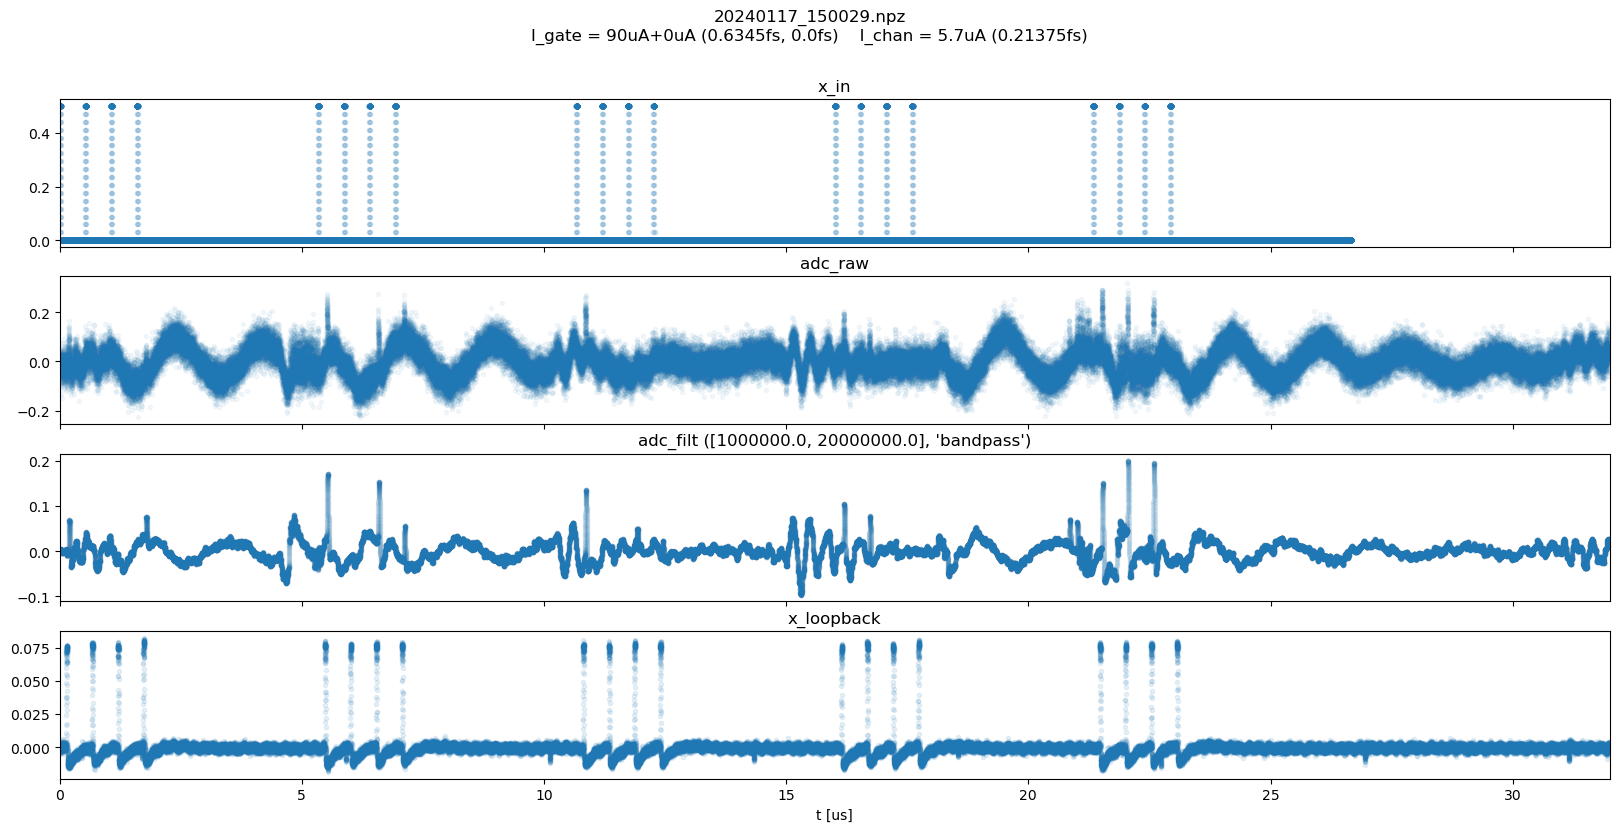

In [54]:
plot_pulses(2,num_bursts,0,32,([1e6, 20e6], 'bandpass'),True,True,False)

In [1572]:
# manual reset
set_dac_scale_offset([0]*8, 0 + dac_bias_correction)

In [47]:
def plot_pulses(captured_channels, n_burst, t_min, t_max, filter_cfg=([1e6, 20e6], 'bandpass'), plot_dac=False, plot_loopback=False, save_fig=False):
    plots = 2
    if plot_loopback:
        plots += 1
    if plot_dac:
        plots += 1
    f, ax = plt.subplots(plots,1,sharex=True,figsize=(20,plots*2+1),dpi=100)
    tvec = np.linspace(0,(8//captured_channels)*adc_buffer_data_depth*parallel_samples/adc_fsamp,(8//captured_channels)*adc_buffer_data_depth*parallel_samples,endpoint=False)
    
    sos = scipy.signal.butter(2,filter_cfg[0],btype=filter_cfg[1],output='sos',fs=adc_fsamp)
    zi = scipy.signal.sosfilt_zi(sos)
    
    awg_tvec = np.linspace(0,n_burst*awg_frame_depth*parallel_samples/dac_fsamp,n_burst*awg_frame_depth*parallel_samples,endpoint=False)
    
    titles = []

    # plot AWG buffer
    current_plot = 0
    if plot_dac:
        ax[current_plot].plot(awg_tvec*1e6, np.tile(awg_buffer[0:awg_frame_depth*parallel_samples]/2**sample_width,n_burst), '.', alpha=0.2)
        titles.append('x_in')
        current_plot += 1
    
    # plot raw ADC data + filtered ADC data
    x0 = np.mean(samples[0][0:int(50e-9*dac_fsamp)])
    filt, _ = scipy.signal.sosfilt(sos, samples[0]/2**sample_width, zi=zi*x0/2**sample_width)
    ax[current_plot].plot(tvec*1e6, samples[0]/2**sample_width, '.', alpha=0.05)
    titles.append('adc_raw')
    current_plot += 1
    ax[current_plot].plot(tvec*1e6, filt, '.', alpha=0.05)
    titles.append(f'adc_filt {filter_cfg}')
    current_plot += 1
    # optional: plot loopback data
    if plot_loopback:
        ax[current_plot].plot(tvec*1e6, samples[1]/2**sample_width, '.', alpha=0.1)
        titles.append('x_loopback')
        current_plot += 1
    ax[0].set_xlim(t_min, t_max)
    ax[-1].set_xlabel('t [us]')
    for i in range(plots):
        ax[i].set_title(titles[i], fontsize=12)
    f.suptitle(f'{savefile}.npz\nI_gate = {gate_ampl_uA}uA+{gate_bias_uA}uA ({round(gate_ampl_fs,5)}fs, {round(gate_bias_fs,5)}fs)    I_chan = {chan_bias_uA}uA ({round(chan_bias_fs,5)}fs)')
    if save_fig:
        f.savefig(f'figures/awg_pulse_test_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png', facecolor='white', transparent=False)
    

In [55]:
ol?

Type:            Overlay
String form:     <pynq.overlay.Overlay object at 0xffff58abfdc0>
File:            /usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/overlay.py
Docstring:      
Default documentation for overlay hw/top_20240115_160553.bit. The following
attributes are available on this overlay:

IP Blocks
----------
axi_dma_0            : pynq.lib.dma.DMA
usp_rf_data_converter_0 : pynq.overlay.DefaultIP
sample_discriminator_config/fifo : axififo.AxiStreamFifoDriver
buffer_config/fifo   : axififo.AxiStreamFifoDriver
adc_mux_config/fifo  : axififo.AxiStreamFifoDriver
buffer_start_stop/fifo : axififo.AxiStreamFifoDriver
awg_frame_depth/fifo : axififo.AxiStreamFifoDriver
awg_burst_length/fifo : axififo.AxiStreamFifoDriver
awg_start_stop/fifo  : axififo.AxiStreamFifoDriver
awg_trigger_out_config/fifo : axififo.AxiStreamFifoDriver
dac_mux_config/fifo  : axififo.AxiStreamFifoDriver
trigger_manager_config/fifo : axififo.AxiStreamFifoDriver
dac_scale_offset_config/fifo : axifi

In [ ]:
def raw_plot(channels_to_plot, t_min, t_max, save_fig=False):
    f, ax = plt.subplots(channels_to_plot,1,sharex=True,figsize=(12,8),dpi=90)
    tvec = np.linspace(0,(8//channels_to_plot)*adc_buffer_data_depth*parallel_samples/adc_fsamp,(8//channels_to_plot)*adc_buffer_data_depth*parallel_samples,endpoint=False)
    sos = scipy.signal.butter(4,20e6,btype='low',output='sos',fs=adc_fsamp)
    for channel in range(channels_to_plot):
        ax[channel].plot(tvec*1e6, samples[channel]/2**sample_width, '.', alpha=0.05)
        ax[channel].plot(tvec*1e6, scipy.signal.sosfilt(sos, samples[channel]/2**sample_width), '.', alpha=0.2)
        #ax[channel].set_ylim(-0.1, 0.7)
    ax[0].set_xlim(t_min, t_max)
    ax[channels_to_plot-1].set_xlabel('t [us]')
    if save_fig:
        f.savefig(f'figures/awg_pulse_test_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png', facecolor='white', transparent=False)

def sparse_plot(channels_to_plot, save_fig=False):
    f, ax = plt.subplots(channels_to_plot,1,sharex=True,figsize=(12,8),dpi=90)
    sample_index_bits = clog2(adc_buffer_data_depth*num_channels)
    print(f'sample_index_bits = {sample_index_bits}')
    for channel in range(channels_to_plot):
        t0 = int(timestamps[channel][0]) >> sample_index_bits
        for batch in range(num_timestamps[channel]):
            tstamp = int(timestamps[channel][batch])
            t = tstamp >> sample_index_bits
            if t < t0:
                t0 -= 2**(tstamp_width-sample_index_bits)
            dt = t - t0
            index_start = tstamp & ((1 << sample_index_bits) - 1)
            index_end = num_samples[channel]//parallel_samples if batch == num_timestamps[channel] - 1 else (int(timestamps[channel][batch+1]) & ((1 << sample_index_bits) - 1))
            tvec = np.linspace(dt*parallel_samples/adc_fsamp,(dt+index_end-index_start)*parallel_samples/adc_fsamp,(index_end-index_start)*parallel_samples,endpoint=False)
            ax[channel].plot(tvec*1e9, samples[channel][index_start*parallel_samples:index_end*parallel_samples]/2**sample_width, '.')
    #ax[0].set_xlim(0, 400)
    ax[channels_to_plot-1].set_xlabel('t [ns]')
    if save_fig:
        f.savefig(f'figures/awg_pulse_test_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png', facecolor='white', transparent=False)

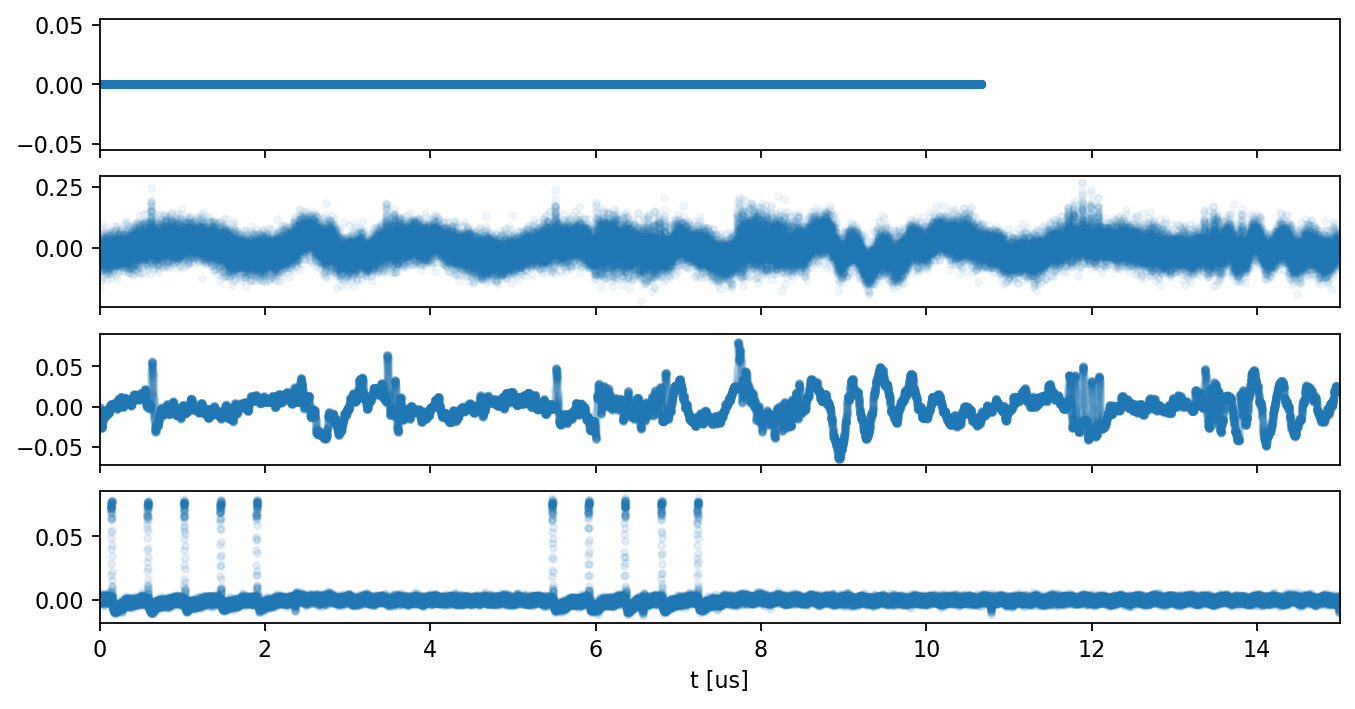

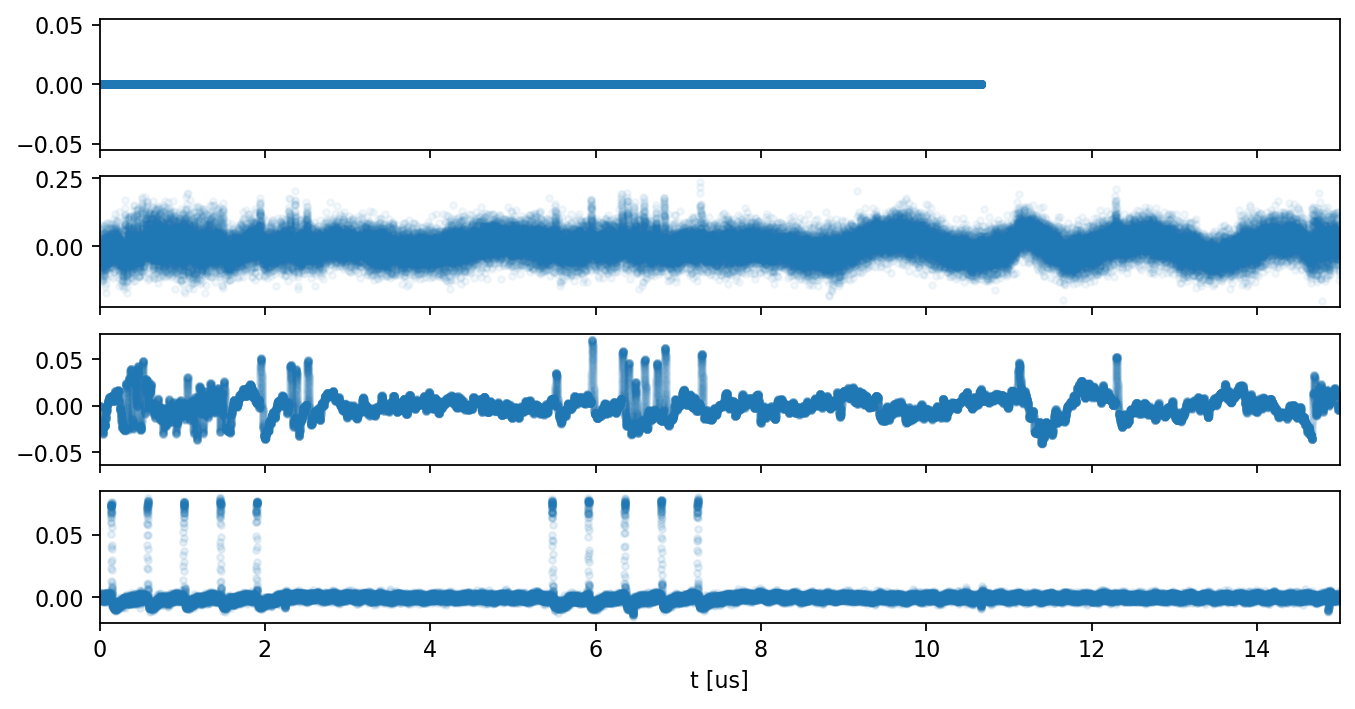

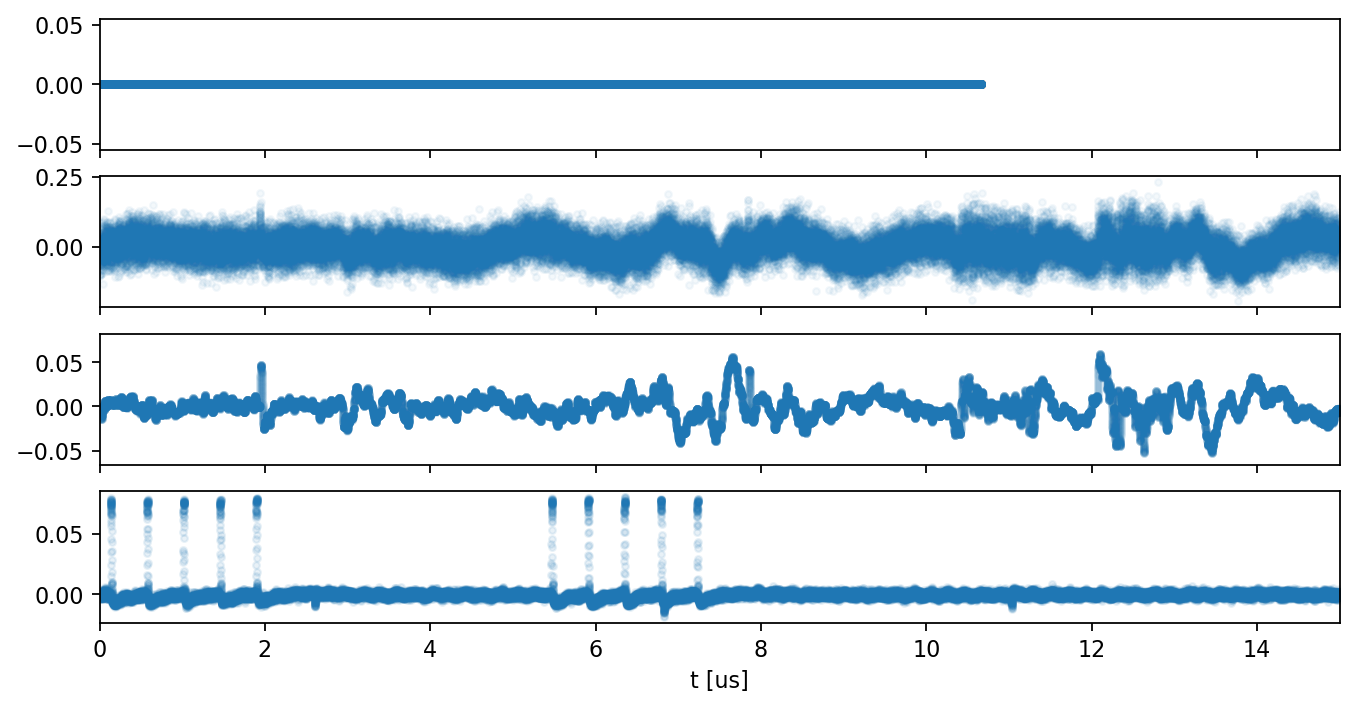

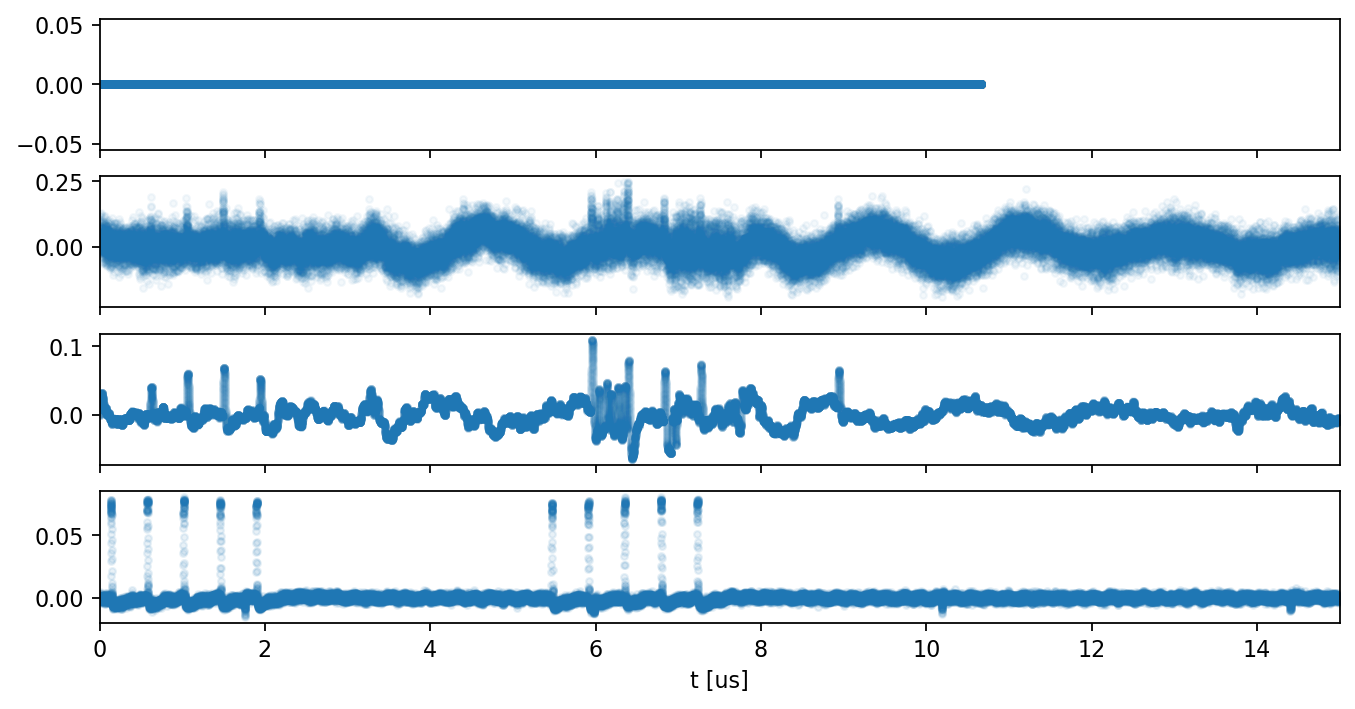

In [13]:
# get data for plots:
times = ['20240116_225849', '20240116_230041', '20240116_230206', '20240116_230448']
for dt in times:
    data = np.load(f'data/{dt}.npz')
    adc_buffer = data['dma_data']
    timestamps, samples, num_timestamps, num_samples = parse_adc_data(data['num_active_channels'])
    plot_pulses(2,2,0,15,([1e6, 20e6], 'bandpass'),True,True,False)
    np.savez_compressed(f'data/{dt}_parsed.npz', samples=samples, num_samples=num_samples, num_channels=data['num_active_channels'], gate_ampl_fs=data['gate_ampl_fs'], chan_bias_fs=data['chan_bias_fs'])